### No + ZNE

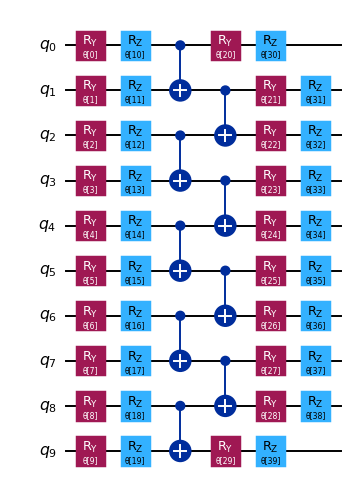

In [ ]:
from qiskit.circuit.library import EfficientSU2

n_qubits = 10
reps = 1

circuit = EfficientSU2(n_qubits, entanglement="pairwise", reps=reps)

circuit.decompose().draw("mpl", scale=0.7)

In [ ]:
from qiskit.quantum_info import SparsePauliOp

# Z on the last qubit (index -1) with coefficient 1.0
#observable = SparsePauliOp.from_sparse_list([("Z", [-1], 1.0)], num_qubits=n_qubits)
observable = SparsePauliOp.from_list([("Z"*n_qubits, 1.0)])
print(observable)

SparsePauliOp(['ZZZZZZZZZZ'],
              coeffs=[1.+0.j])


Mirroring the Circuit

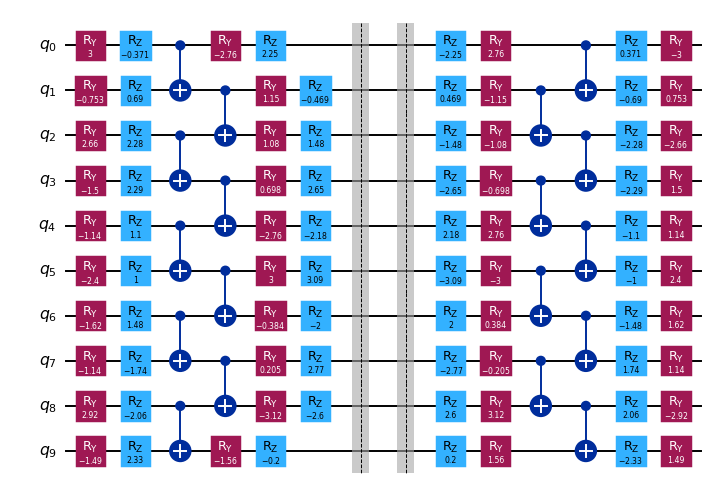

In [ ]:
import numpy as np
from qiskit.circuit.library import UnitaryOverlap

# Generate random parameters
rng = np.random.default_rng(1234)
params = rng.uniform(-np.pi, np.pi, size=circuit.num_parameters)

# Assign the parameters to the circuit
assigned_circuit = circuit.assign_parameters(params)

# Add a barrier to prevent circuit optimization of mirrored operators
assigned_circuit.barrier()

# Construct mirror circuit
mirror_circuit = UnitaryOverlap(assigned_circuit, assigned_circuit)

mirror_circuit.decompose().draw("mpl", scale=0.7)

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='usc/ee520-g/ee520-project',
    token='237d68fbbba3ab1f5663ff574c5813bdd86d098f23b42f6661e7a29846bc3c5653214936822f97fe8e6a53226ca724e19b64baabd705749d8d534de335756557'
)

# Or save your credentials on disk.
# QiskitRuntimeService.save_account(channel='ibm_quantum', instance='usc/ee520-g/ee520-project', token='<IBM Quantum API key>')

backend = service.least_busy(min_num_qubits=127)

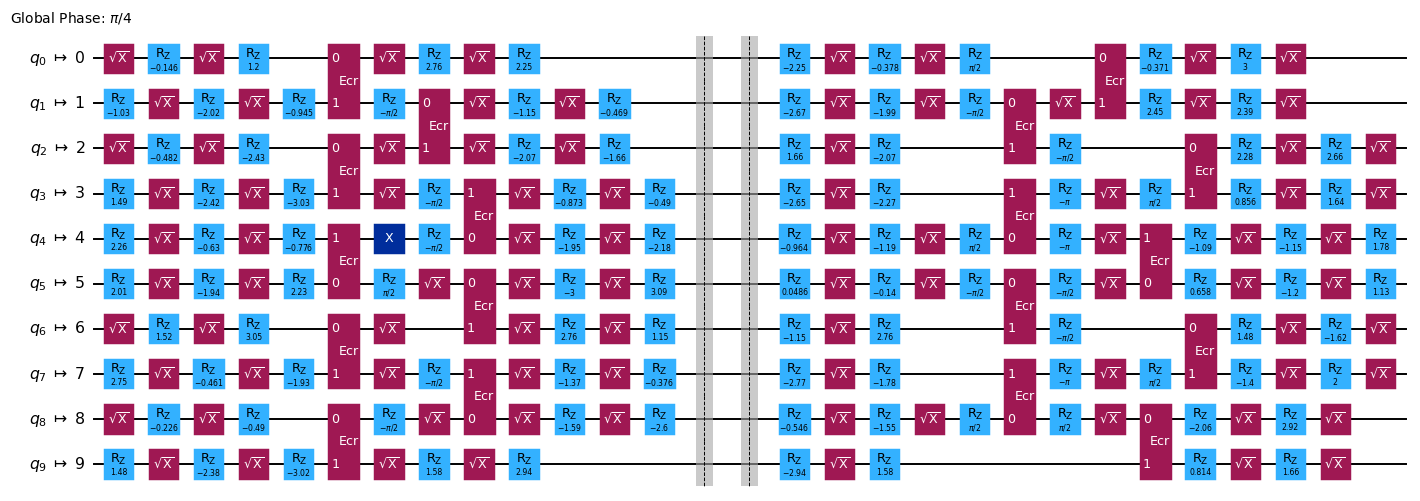

In [ ]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pass_manager = generate_preset_pass_manager(
    optimization_level=1, backend=backend, seed_transpiler=1234
)
isa_circuit = pass_manager.run(mirror_circuit)

isa_circuit.draw("mpl", idle_wires=False, scale=0.7, fold=-1)

In [ ]:
isa_observable = observable.apply_layout(isa_circuit.layout)

print("Original observable:")
print(observable)
print()
print("Observable with layout applied:")
print(isa_observable)

Original observable:
SparsePauliOp(['ZZZZZZZZZZ'],
              coeffs=[1.+0.j])

Observable with layout applied:
SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZZZZZZZZZ'],
              coeffs=[1.+0.j])


In [ ]:
from qiskit_ibm_runtime import Batch, EstimatorV2 as Estimator

pub = (isa_circuit, isa_observable)

jobs = []

with Batch(backend=backend) as batch:
    estimator = Estimator(mode=batch)
    # Set number of shots
    estimator.options.default_shots = 10000
    # Disable runtime compilation and error mitigation
    estimator.options.resilience_level = 0

    # Run job with no error mitigation
    job0 = estimator.run([pub])
    jobs.append(job0)

    # Add zero-noise extrapolation (ZNE)
    estimator.options.resilience.zne_mitigation = True
    estimator.options.resilience.zne.amplifier = ("gate_folding")
    estimator.options.resilience.zne.noise_factors = (1, 2, 3, 4, 5)
    estimator.options.resilience.zne.extrapolator = ("exponential")
    job1 = estimator.run([pub])
    jobs.append(job1)

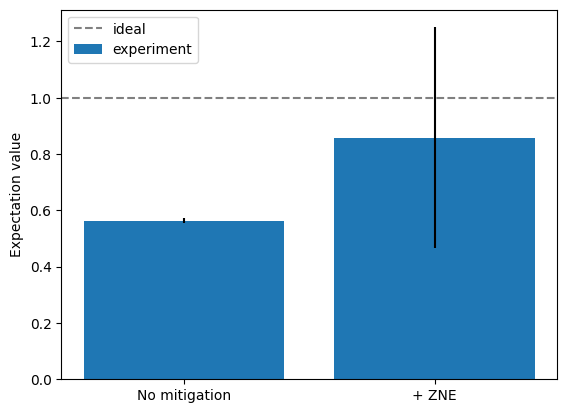

In [ ]:
import matplotlib.pyplot as plt

# Retrieve the job results
results = [job.result() for job in jobs]

# Unpack the PUB results (there's only one PUB result in each job result)
pub_results = [result[0] for result in results]

# Unpack the expectation values and standard errors
expectation_vals = np.array([float(pub_result.data.evs) for pub_result in pub_results])
standard_errors = np.array([float(pub_result.data.stds) for pub_result in pub_results])

# Plot the expectation values
fig, ax = plt.subplots()
labels = ["No mitigation", "+ ZNE"]
ax.bar(range(len(labels)), expectation_vals, yerr=standard_errors, label="experiment")
ax.axhline(y=1.0, color="gray", linestyle="--", label="ideal")
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels)
ax.set_ylabel("Expectation value")
ax.legend(loc="upper left")

plt.show()